# Scrapping indice picada

In [1]:
import pandas as pd
import random
import requests
import json
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import re
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
from typing import Optional, Dict, Callable

def get_coto(url: str) -> Optional[float]:
    headers = {
        'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.103 Safari/537.36'
    }
    try:
        response = requests.get(url, headers=headers)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, 'html.parser')
            product_name = soup.find('h1', class_='product_page').get_text(strip=True)
            product_price = soup.find('span', class_='atg_store_newPrice').get_text(strip=True).replace('$', '').replace('.', '').replace(',', '.')
            print(f'\nOrigin: Scrap BeautifulSoup\nProduct Name: {product_name}\nPrice: {product_price}')
            return float(product_price)
    except requests.RequestException as e:
        print(f'Request failed: {e}')
    return None

def get_jumbo(url: str) -> Optional[float]:
    headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.103 Safari/537.36'}
    try:
        response = requests.get(url, headers=headers)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, 'html.parser')
            script = soup.find('script', {'type': 'application/ld+json'})
            if script:
                data = json.loads(script.string)
                product_name = data.get('name')
                product_price = data.get('offers', {}).get('lowPrice')
                print(f'\nOrigin: Scrap BeautifulSoup\nProduct Name: {product_name}\nPrice: {product_price}')
                return float(product_price)
    except requests.RequestException as e:
        print(f'Request failed: {e}')
    return None

def create_df(articulos: Dict[str, Dict[str, str]], product_key: str) -> pd.DataFrame:
    data_dict = {}
    store_function_mapping: Dict[str, Callable[[str], Optional[float]]] = {
        'coto': get_coto,
        'jumbo': get_jumbo,
        'carrefour': get_jumbo,
        'mercado libre': get_meli
    }
    for store, products in articulos.items():
        if product_key in products and store in store_function_mapping:
            product_price = store_function_mapping[store](products[product_key])
            if product_price is not None:
                data_dict[store] = product_price
    df = pd.DataFrame([data_dict])
    df.index = [datetime.now().strftime('%d-%m-%Y')]
    return df

def mock_data_random_decrease(df: pd.DataFrame, days_back: int, percentage_decrease_min: float, percentage_decrease_max: float) -> pd.DataFrame:
    new_df = df.copy()
    new_df.index = pd.to_datetime(new_df.index, format='%d-%m-%Y')
    last_known_prices = new_df.iloc[-1]
    for day in range(1, days_back + 1):
        random_decrease = random.uniform(percentage_decrease_min, percentage_decrease_max) / 100
        past_date = new_df.index[-1] - timedelta(days=1)
        decreased_prices = last_known_prices * (1 - random_decrease)
        new_df.loc[past_date] = decreased_prices
        last_known_prices = decreased_prices
    new_df.sort_index(inplace=True)
    return new_df

def get_meli(url: str) -> Optional[float]:
    try:
        pattern = r'/MLA-(\d+)'
        match = re.search(pattern, url)
        if match:
            item_id = 'MLA' + match.group(1)
            url = f'https://api.mercadolibre.com/items/{item_id}'
            response = requests.get(url)
            if response.status_code == 200:
                data = response.json()
                product_price = data['price']
                print(f'\nOrigin: API Mercadolibre\nProduct Name: No Aplica\nPrice: {product_price}')
                return float(product_price)
            else:
                print(f"Error fetching item price: {response.status_code} {response.text}")
        else:
            print("Product ID not found in URL.")
    except requests.RequestException as e:
        print(f'Request failed: {e}')
    return None

def plot_timeline(df: pd.DataFrame, item_name: str) -> None:
    sns.set_theme()
    ax = df.plot(kind='line', figsize=(10, 6))
    ax.set_xlabel('Fechas')
    ax.set_ylabel('Precio')
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45)
    ax.set_title(item_name)
    plt.show()


# Cargamos DF

In [8]:
df_raw = pd.read_excel('Canasta Picada.xlsx')
df_raw.rename({'Unnamed: 0':'Items'}, axis=1, inplace=True)

# Formateamos para scrapear

In [9]:
#convertimos el DF a un diccionario

articulos = {}
for _, row in df_raw.iterrows():
    for col in df_raw.columns[1:]:
        if pd.notna(row[col]):
            if col.lower() not in articulos:
                articulos[col.lower()] = {}
            articulos[col.lower()][row['Items'].replace(' ', '_')] = row[col]

# Scrapeamos con distintos metodos segun el sitio


In [6]:
df_list = []
for j in articulos['coto'].keys():
    df = create_df(articulos, j)
    df_list.append((j,df))


Origin: Scrap BeautifulSoup
Product Name: Salamin Tand.Fin Cagnoli Xkg
Price: 19079.00

Origin: Scrap BeautifulSoup
Product Name: Salamin Cagnoli Picado Fino 1 Kg
Price: 19402

Origin: Scrap BeautifulSoup
Product Name: Salamín tandilero Cagnoli picado fino x kg.
Price: 19079

Origin: API Mercadolibre
Product Name: No Aplica
Price: 15389

Origin: Scrap BeautifulSoup
Product Name: Cerveza Lager Imperial  Lata 710 CC
Price: 2530.00

Origin: Scrap BeautifulSoup
Product Name: Cerveza Imperial Rubia 710 Ml
Price: 2530

Origin: Scrap BeautifulSoup
Product Name: Cerveza rubia Imperial lager 710 cc.
Price: 2530

Origin: API Mercadolibre
Product Name: No Aplica
Price: 2909.5

Origin: Scrap BeautifulSoup
Product Name: Papas Fritas Clasicas Lays 40g
Price: 1315.99

Origin: Scrap BeautifulSoup
Product Name: Papas Fritas Lays Clásicas X 40 Gr
Price: 1600

Origin: Scrap BeautifulSoup
Product Name: Papas fritas Krachitos pay 150 g.
Price: 1683
Product ID not found in URL.

Origin: Scrap BeautifulSoup

# Creamos data sintetica y ploteamos

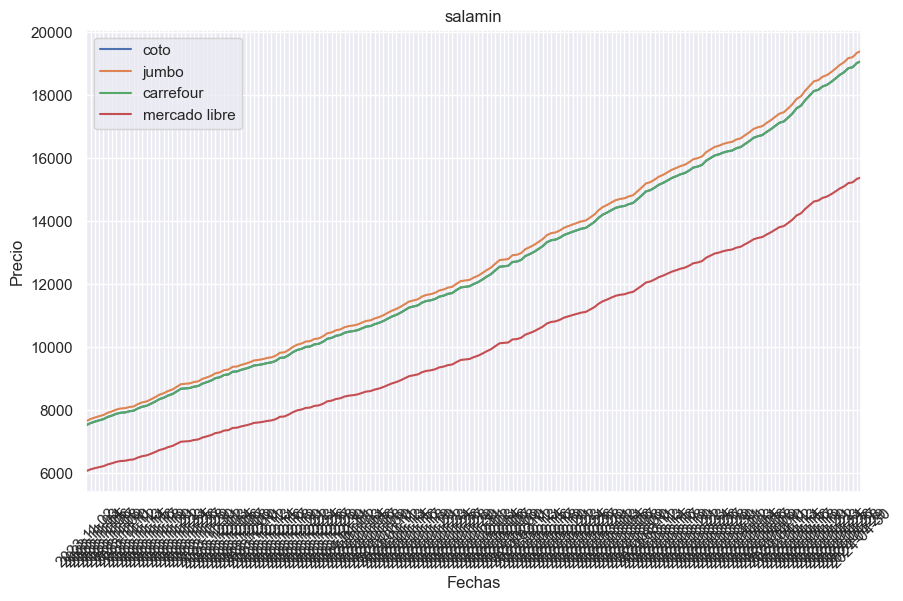

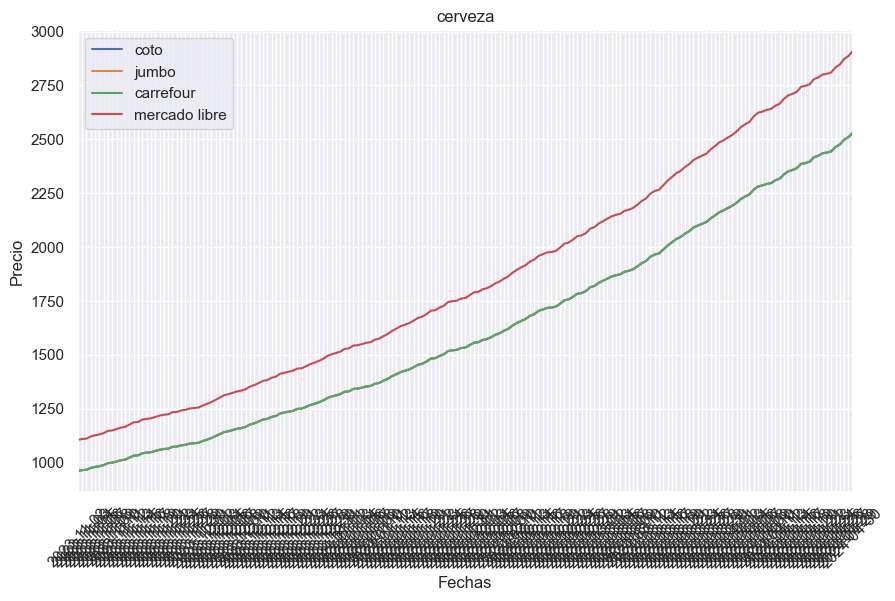

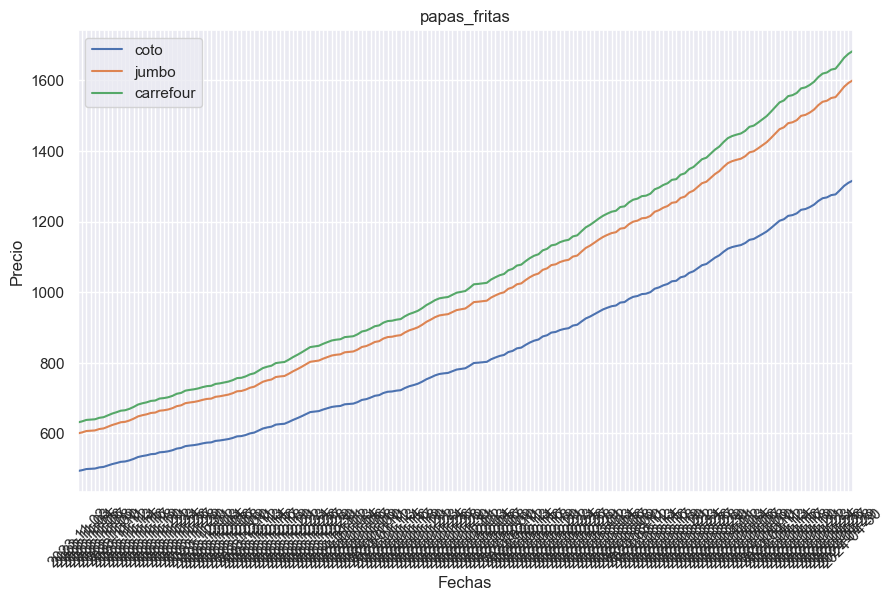

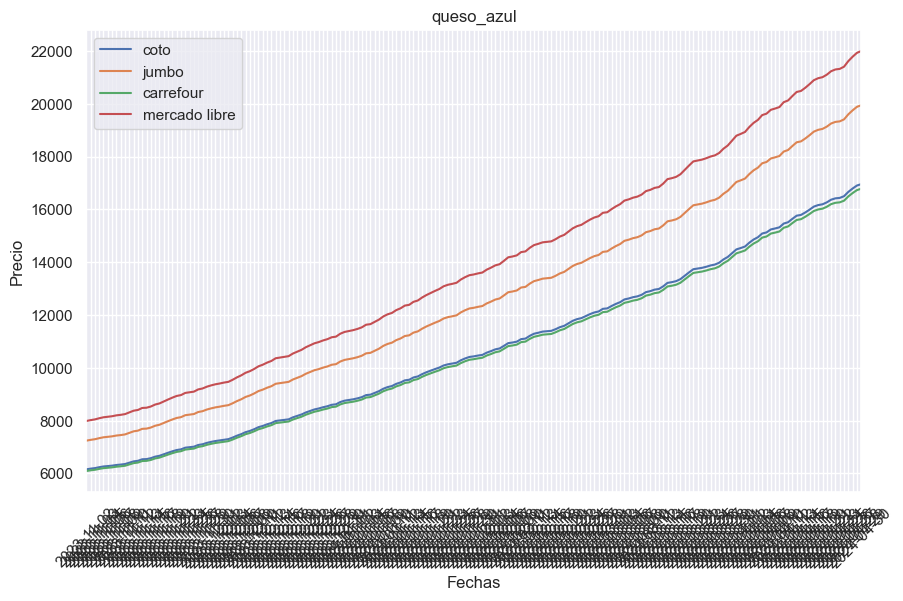

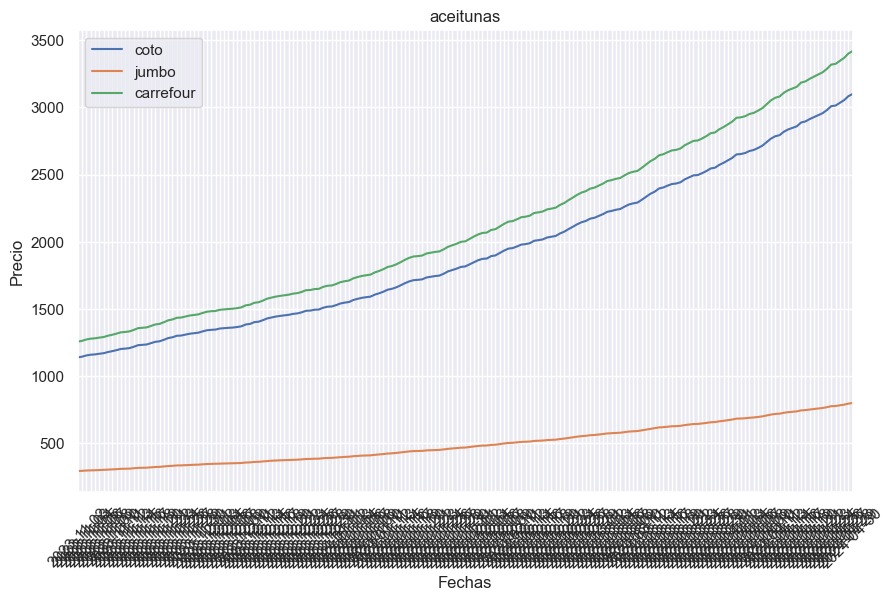

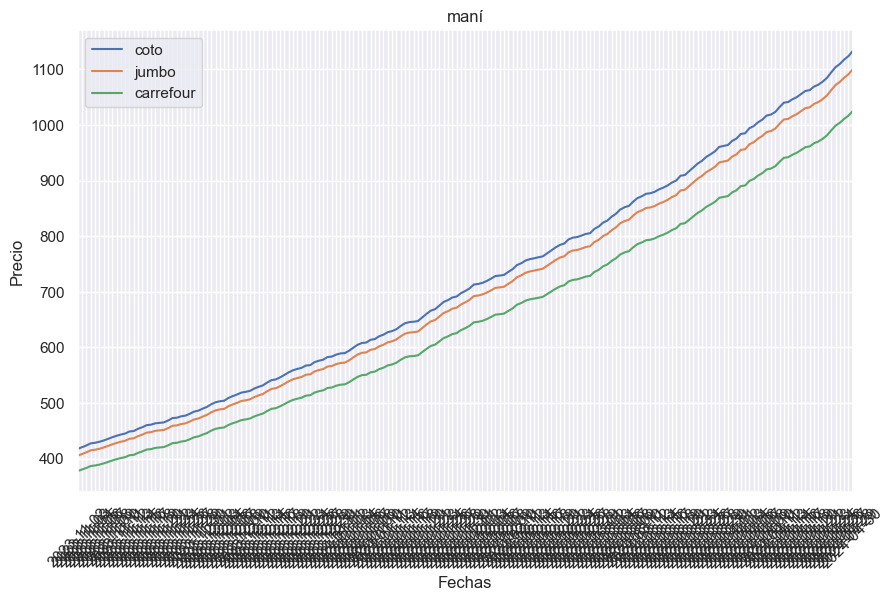

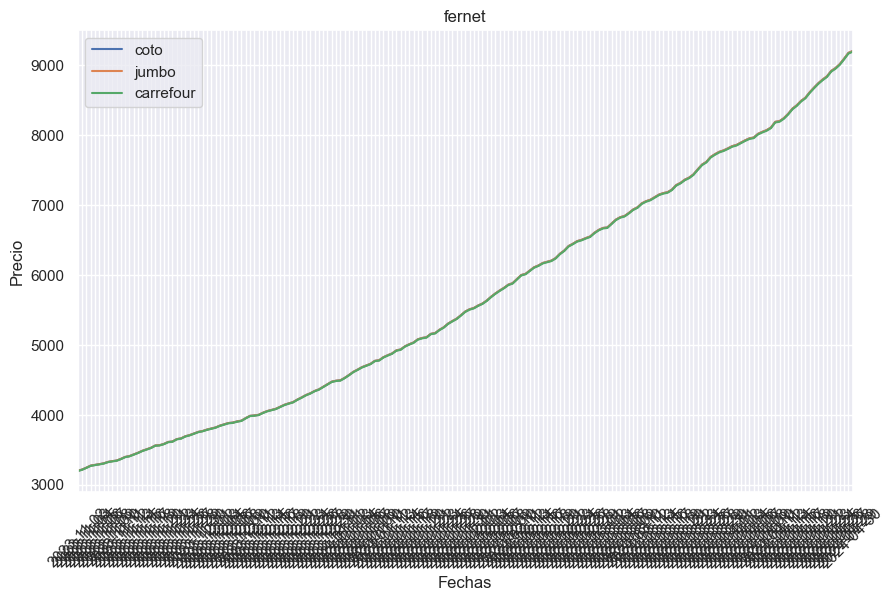

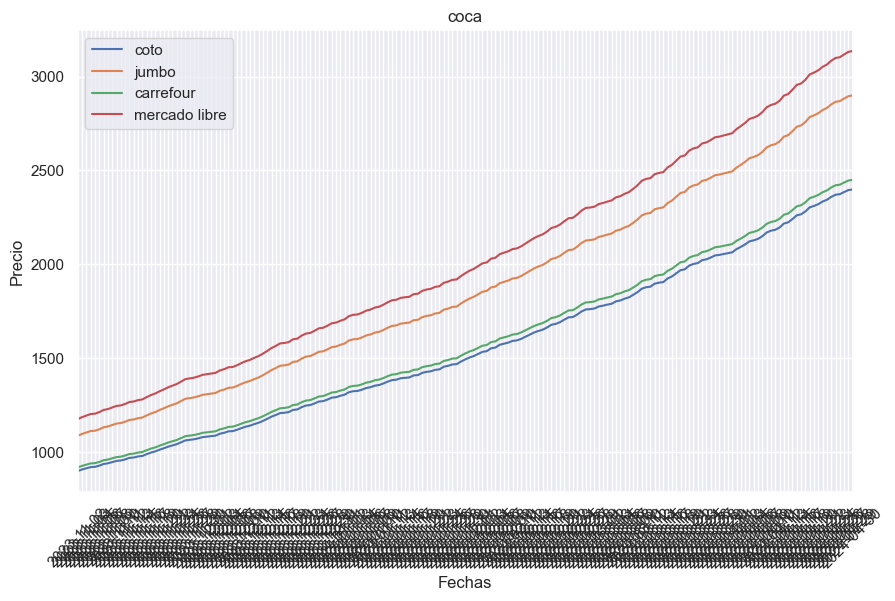

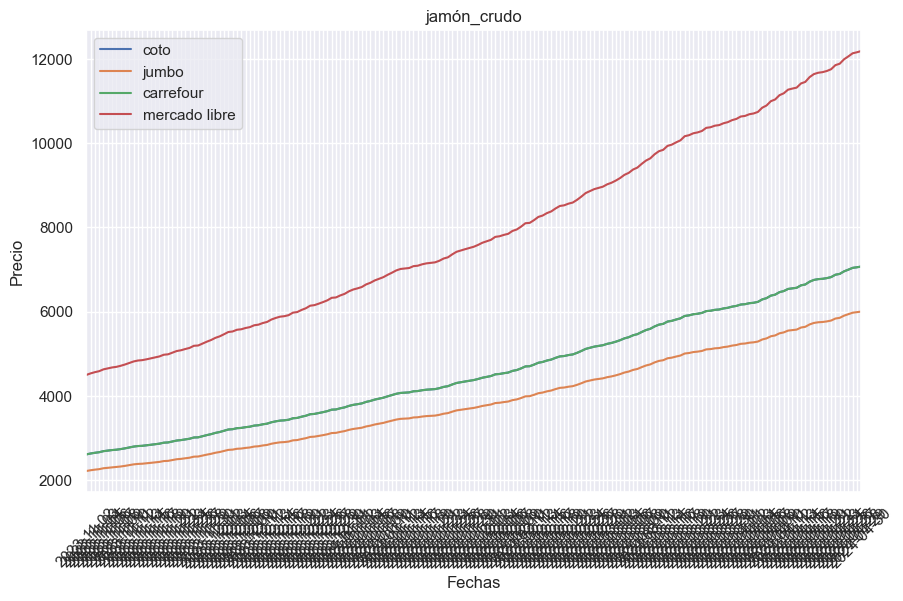

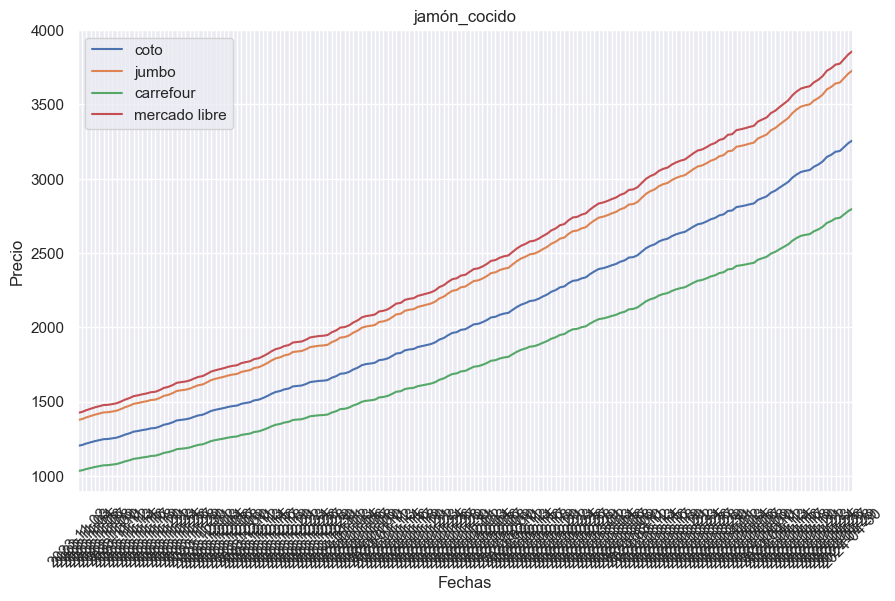

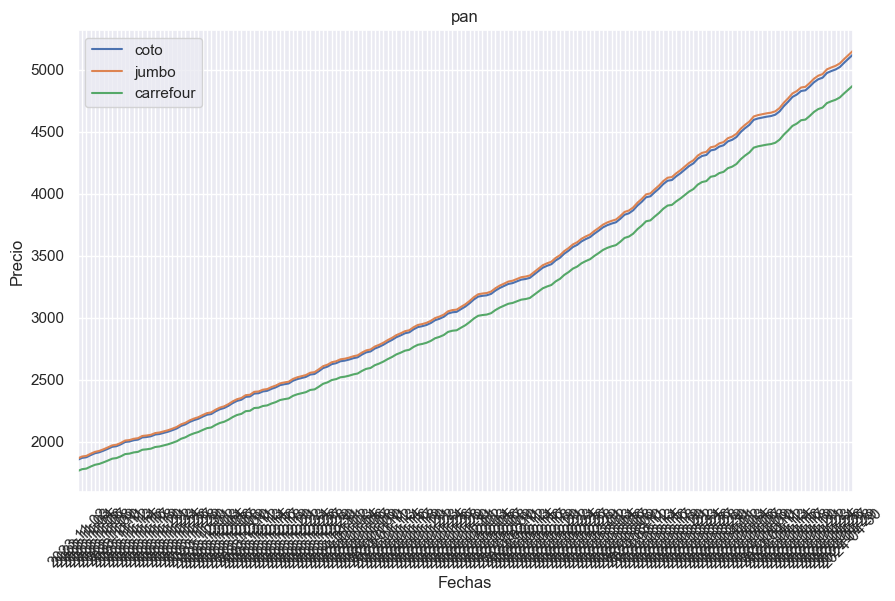

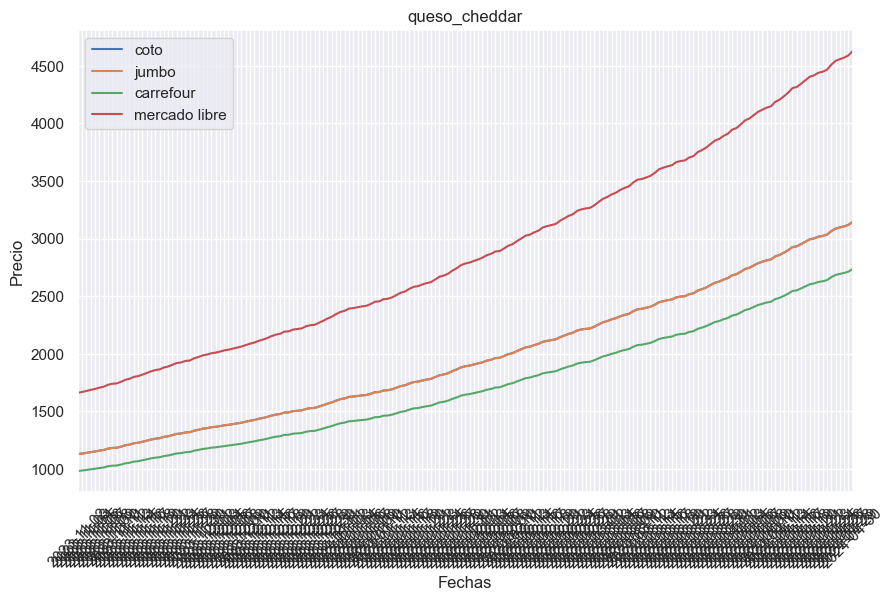

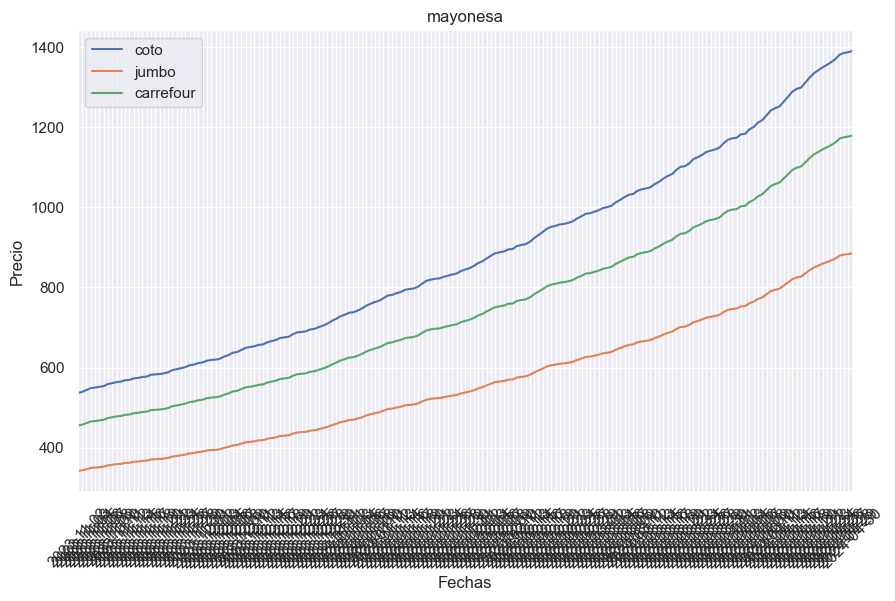

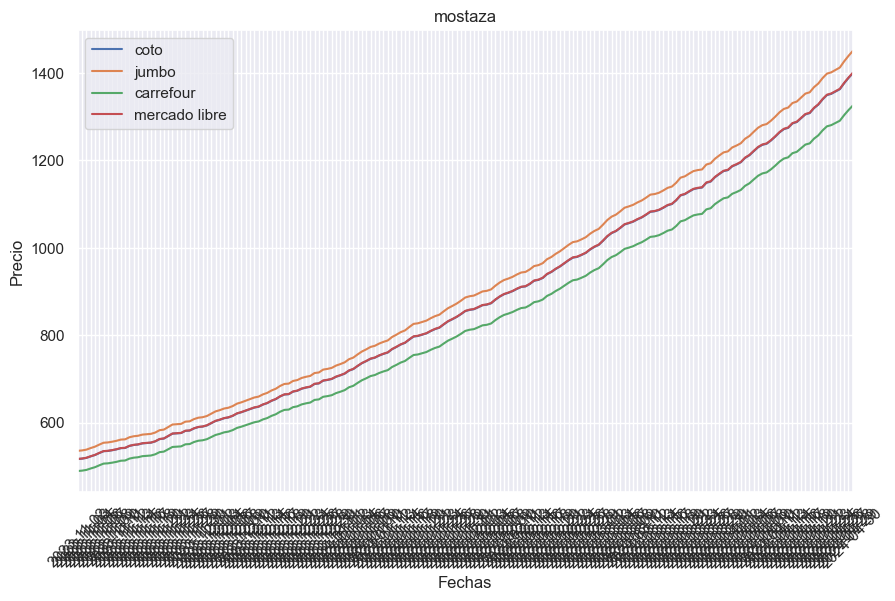

In [7]:
for i in range(len(df_list)):    
    new_df = mock_data_random_decrease(df_list[i][1], 
                                   days_back=180, 
                                   percentage_decrease_min=0.1,
                                   percentage_decrease_max=1)    
    plot_timeline(new_df , df_list[i][0])
    del new_df